In [1]:
import numpy as np
from matplotlib import figure, gridspec,colors

import scanner_interpretation as scani

import healpy as hp

from matplotlib import colors,cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization as vis

import dill

from gammapy.datasets import Datasets
from gammapy.data import DataStore,ObservationFilter

from pathlib import Path
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion, Regions



with open("pickles/mplets.pkl","rb") as f:
    mplets = dill.load(f)

nosource_mask = mplets.table["TEVCAT_DISTANCES_DEG"] >= 0.2
Nmin4_mask = mplets.table["Nmax"] >= 4
Nmin5_mask = mplets.table["Nmax"] >= 5
dt1sec_mask = mplets.table["dt"] <= 1e9
xgal_mask = np.abs(mplets.table["MEDIAN_GLAT"]) > 5

In [23]:
mymask = xgal_mask * nosource_mask
reduced = mplets.table[mymask]
obsids = reduced["OBS_ID"]

current_obs_index = 0

hess1_datastore = DataStore.from_dir("$HESS1")
hess1u_datastore = DataStore.from_dir("$HESS1U")
myobs = hess1_datastore.get_observations([obsids[current_obs_index]])
phottable = myobs[0].events.table

run_dist = scani.sphere_dist(phottable["RA"].data, phottable["DEC"].data, reduced[current_obs_index]["MEDIAN_RA"], reduced[current_obs_index]["MEDIAN_DEC"])

In [ ]:
len(np.unique(mplets.table["OBS_ID"]))/(len(hess1_datastore.obs_ids) + len(hess1u_datastore.obs_ids))

In [ ]:
reduced[reduced["OBS_ID"]==50966]["MEDIAN_RA"].data[0]

In [ ]:
myhist = vis.hist(run_dist,histtype="step",bins="freedman")
plt.xlabel("Angular distance [deg]")
plt.ylabel("Photon counts")
plt.title(f"Angular distance from median RADEC of multiplet to photons in run {obsids[current_obs_index]}")
ax = plt.gca()
ylims = ax.get_ylim()
plt.vlines(5,ylims[0],ylims[1],color="red",ls="--",label="5 deg")
ax.set_ylim(*ylims)
ax.set_xlim(-.5,7)
plt.legend()
# plt.yscale("log")

In [ ]:
myobs[0].obs_info["LIVETIME"]/60

In [20]:
phottable[:2]

EVENT_ID,EVENT_ID_HESS,BUNCH_ID_HESS,OBS_ID,TIME,MULTIP,RA,DEC,DIR_ERR,SKYX_RADEC,SKYY_RADEC,DETX,DETY,FOV_ALTAZ_THETA,FOV_ALTAZ_PHI,FOV_ALTAZ_LON,FOV_ALTAZ_LAT,FOV_RADEC_THETA,FOV_RADEC_PHI,FOV_RADEC_LON,FOV_RADEC_LAT,ALT,AZ,COREX,COREY,CORE_ERR,XMAX,XMAX_ERR,ENERGY,ENERGY_ERR,HIL_MSW,HIL_MSW_ERR,HIL_MSL,HIL_MSL_ERR
,,,,s,,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,m,m,m,m,m,TeV,TeV,,,,
int64,uint32,uint32,uint32,float64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
120259084333,45,28,18361,96157131.04546523,2,84.15269,23.469427,0.061122123,-0.95593166,0.47646198,-0.888458,-0.5927528,1.0680287,-33.712044,-0.888458,-0.5927528,1.0679687,116.4929,0.47645098,0.95580995,37.471977,331.1664,-143.24669,-81.35084,1e-45,172.71237,1.0579411e-07,0.67420715,1.0,-1.0197905,0.26451847,-0.7061351,0.35866004
120259084358,70,28,18361,96157131.22693157,2,83.71886,21.537926,0.0,0.9765909,0.07956559,0.4162463,0.88698065,0.97978663,115.137985,0.4162463,0.88698065,0.9797312,-94.65776,0.07956554,-0.9764953,38.955517,329.51102,751.4099,-405.82053,1e-45,106.964645,8.6040913e-10,9.423786,1.0,-1.0877063,0.21198279,-0.45175344,0.30176064


In [27]:
myobs[0].obs_info

{'EXTNAME': 'EVENTS',
 'CREATOR': 'SASH FITS::EventListWriter',
 'TELESCOP': 'HESS',
 'ORIGIN': 'H.E.S.S. Collaboration',
 'INSTRUME': 'H.E.S.S. Phase I',
 'EV_CLASS': 'std_ImPACT',
 'OBS_ID': 18361,
 'TSTART': 96157130.0,
 'TSTOP': 96158011.0,
 'MJDREFI': 51910,
 'MJDREFF': 0.000742870370370241,
 'TIMEUNIT': 's',
 'TIMESYS': 'TT',
 'TIMEREF': 'local',
 'TASSIGN': 'Namibia',
 'TELAPSE': 0,
 'ONTIME': 881.0,
 'LIVETIME': 881.0,
 'DEADC': 1.0,
 'OBJECT': 'Crab Nebula',
 'RA_OBJ': 83.633333333333,
 'DEC_OBJ': 22.014444444444,
 'RA_PNT': 83.633333333333,
 'DEC_PNT': 22.514444444444,
 'GLON_PNT': 184.133314364185,
 'GLAT_PNT': -5.51637925194063,
 'ALT_PNT': 37.6661202492352,
 'AZ_PNT': 327.963142353231,
 'RADECSYS': 'FK5',
 'EQUINOX': 2000,
 'CONV_DEP': 0.0,
 'CONV_RA': 83.633333333333,
 'CONV_DEC': 22.014444444444,
 'OBS_MODE': 'WOBBLE',
 'N_TELS': 3,
 'TELLIST': '2,3,4',
 'GEOLAT': -23.2717777777778,
 'GEOLON': 16.5002222222222,
 'ALTITUDE': 1835.0,
 'MUONEFF': 0.0940089424451192,
 'MUONC

7


(96157130.0, 96158011.0)

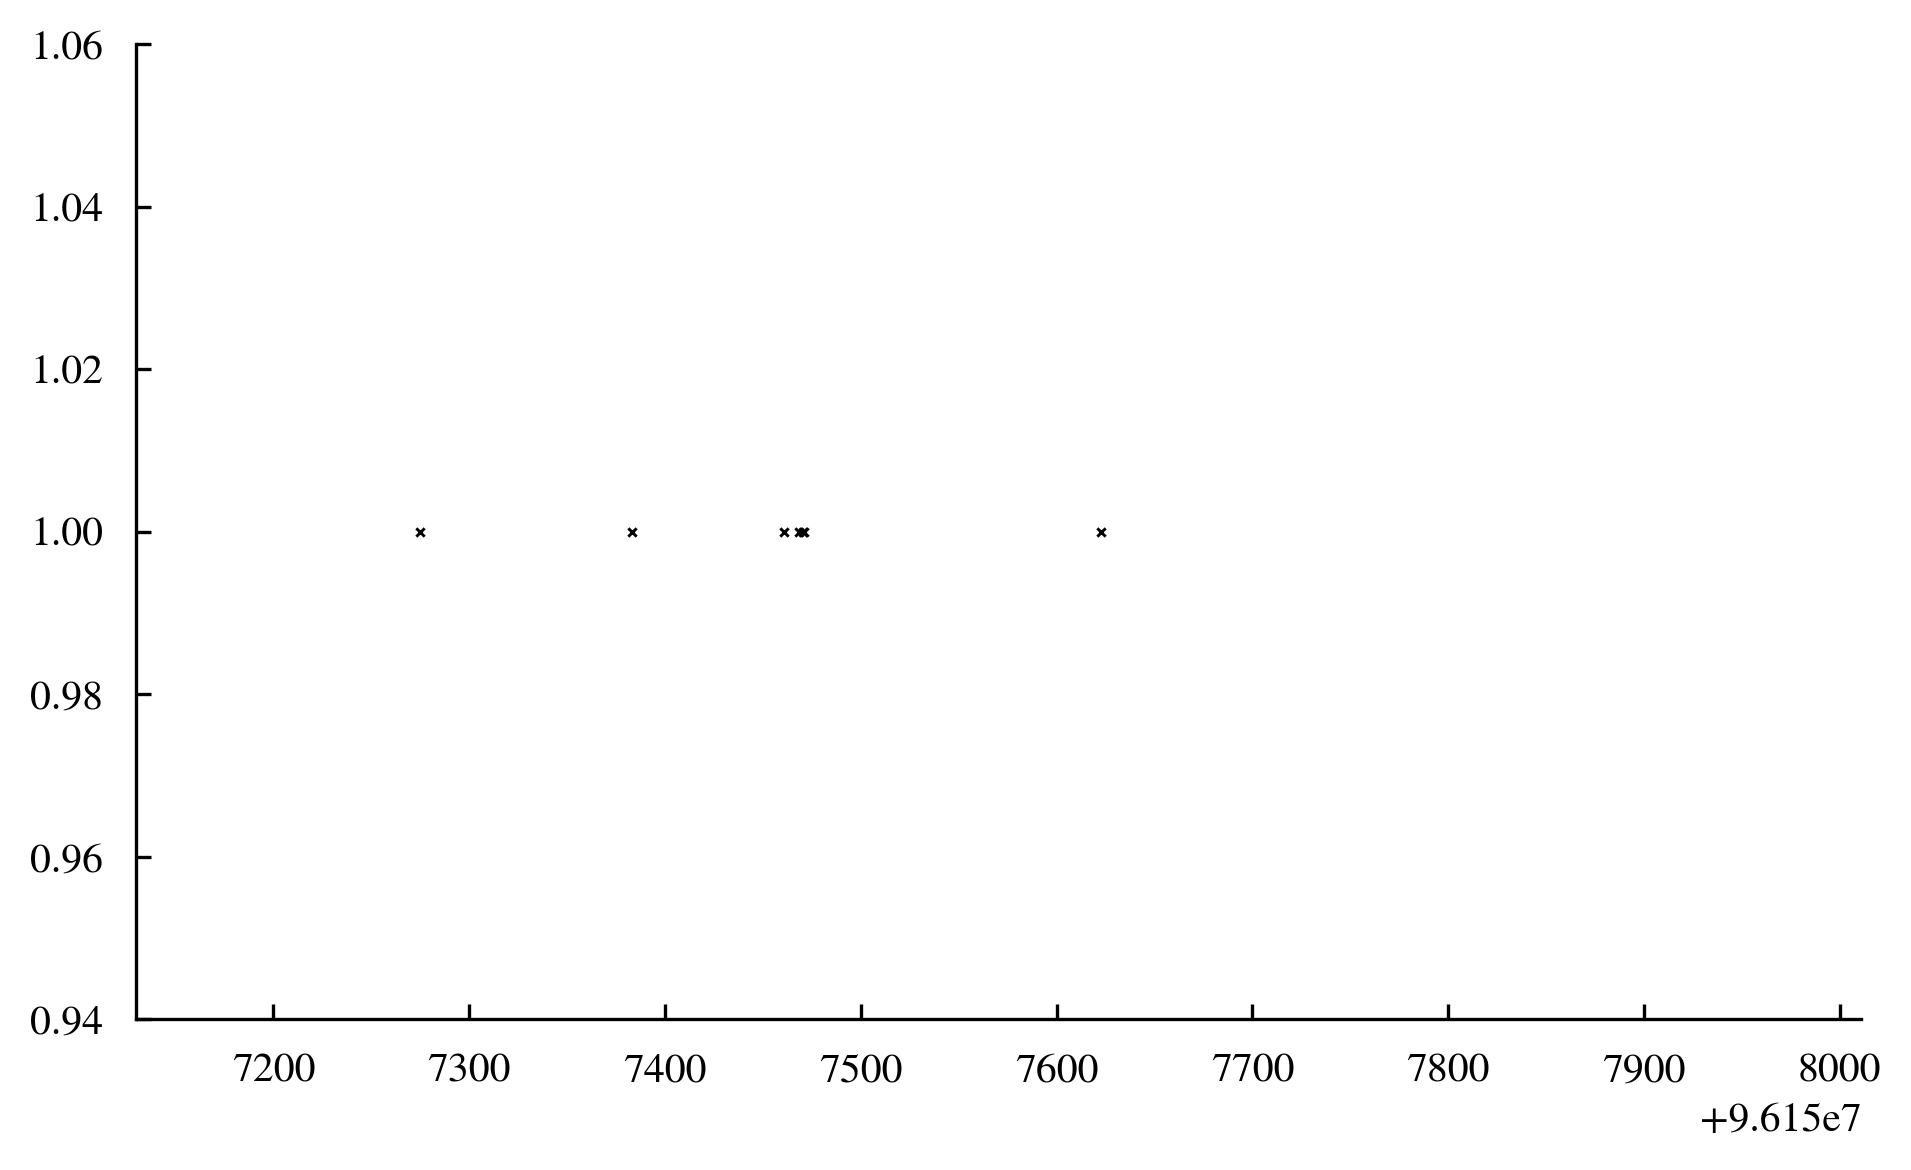

In [28]:
mask = run_dist < 0.1
photoncount = len(phottable[mask][:])#/myobs[0].obs_info["LIVETIME"]/60
import matplotlib.pyplot as plt
print(photoncount)
plt.scatter(phottable[mask]["TIME"],[1 for i in range(photoncount)],s=4,marker="x")
plt.xlim(myobs[0].obs_info["TSTART"],myobs[0].obs_info["TSTOP"])

In [29]:
from scipy.stats import expon
dt_run = np.diff(np.sort(phottable["TIME"]))
dt_mask = np.diff(np.sort(phottable[mask]["TIME"]))
params_run = expon.fit(dt_run)
params_mask = expon.fit(dt_mask)
print(f"params_run : {params_run}")
print(f"params_mask : {params_mask}")

params_run : (0.0007040500640869141, 0.354088208390204)
params_mask : (0.7282290458679199, 57.2406493028005)


In [43]:
lambda_mask_fit = 1/params_mask[1]
rate_boe = len(phottable[mask])/myobs[0].obs_info["LIVETIME"]
print(lambda_mask_fit,rate_boe)

0.017470102316800153 0.007945516458569807


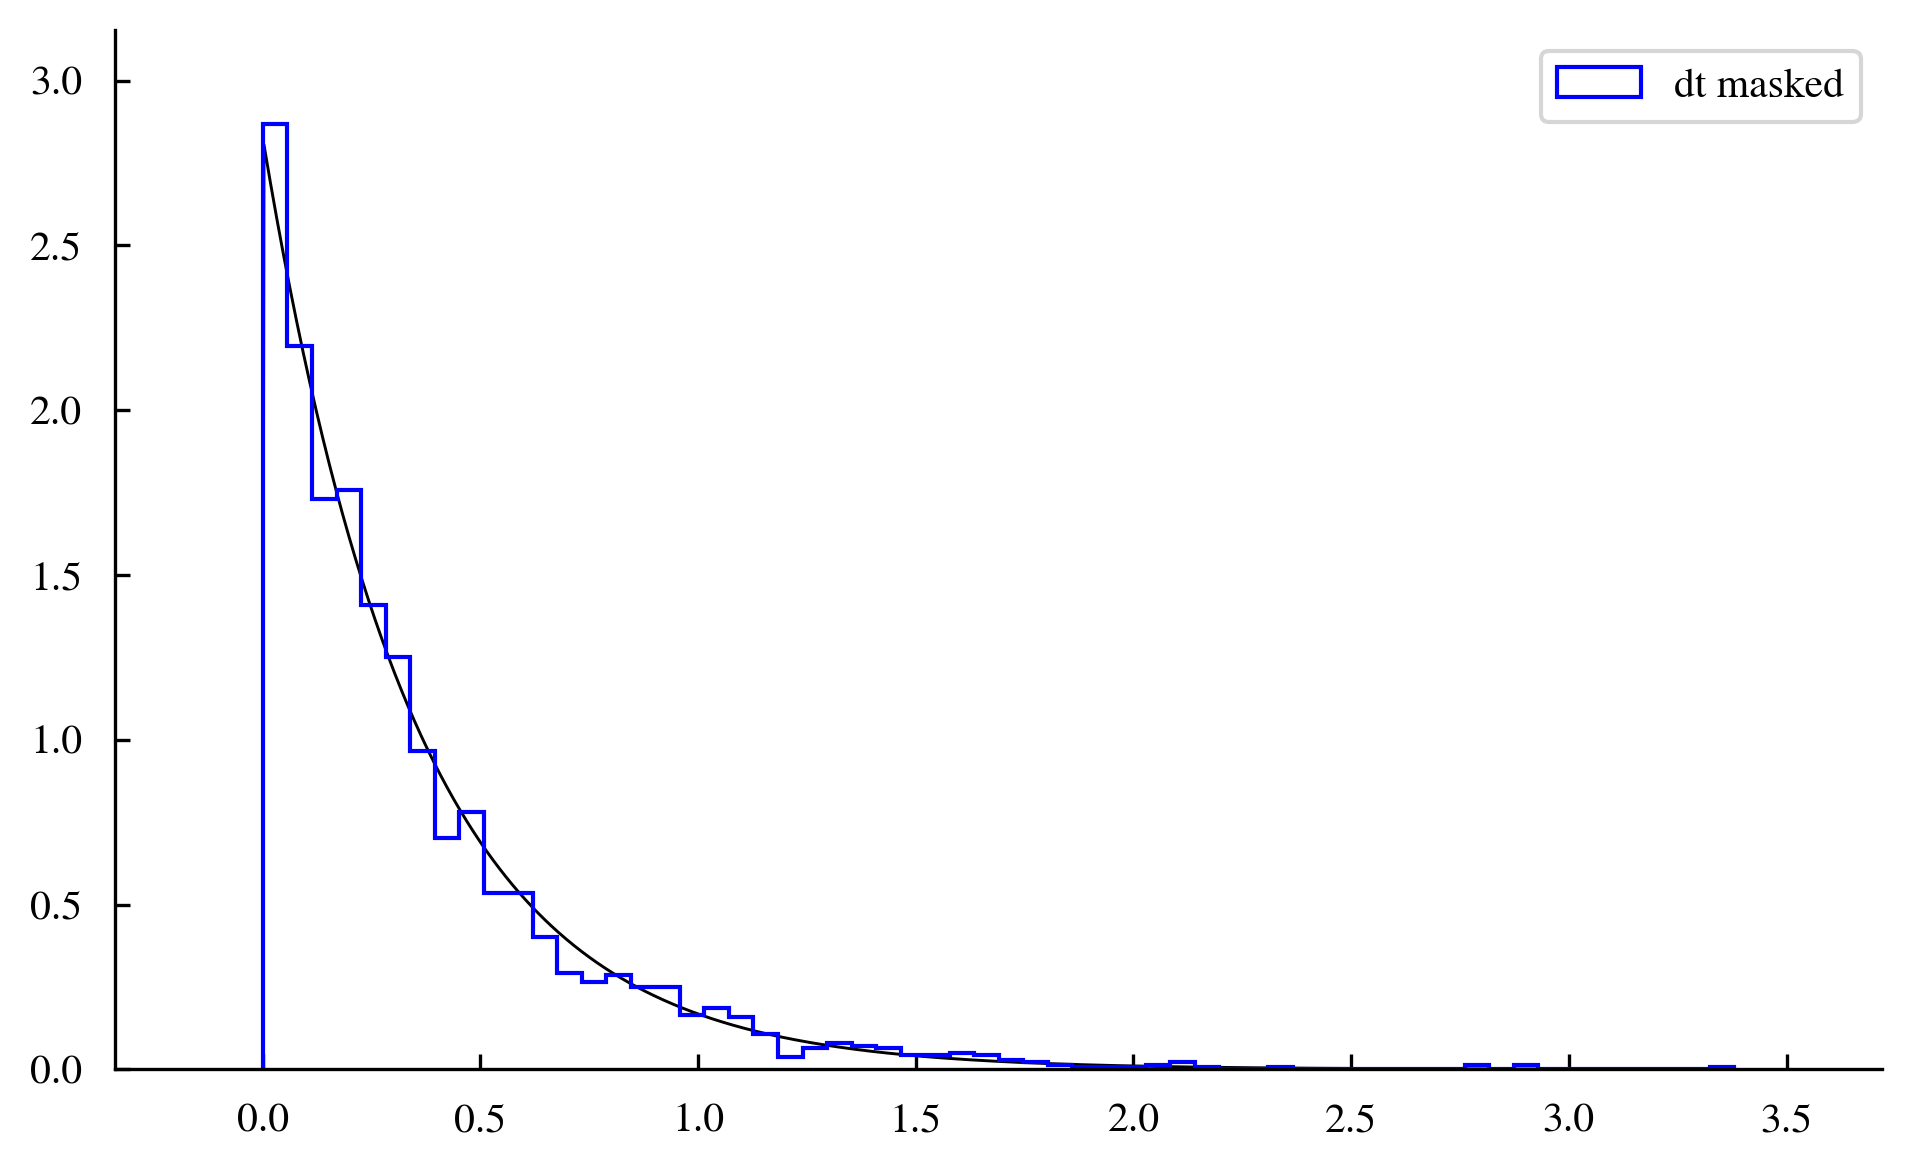

In [41]:
# plt.hist(expon.rvs(*params_run,int(1e3)),histtype="step",label="rvs hist",density=True)
x = np.linspace(0,3,1000)
plt.plot(x,expon.pdf(x,*params_run))
plt.hist(dt_run,label="dt masked",density=True,histtype="step",color="blue")
plt.legend()

In [33]:
rate_run = len(phottable)/myobs[0].obs_info["LIVETIME"]
rate_masked_run = len(phottable[mask])/myobs[0].obs_info["LIVETIME"]
print(rate_run,rate_masked_run)

2.819523269012486 0.007945516458569807


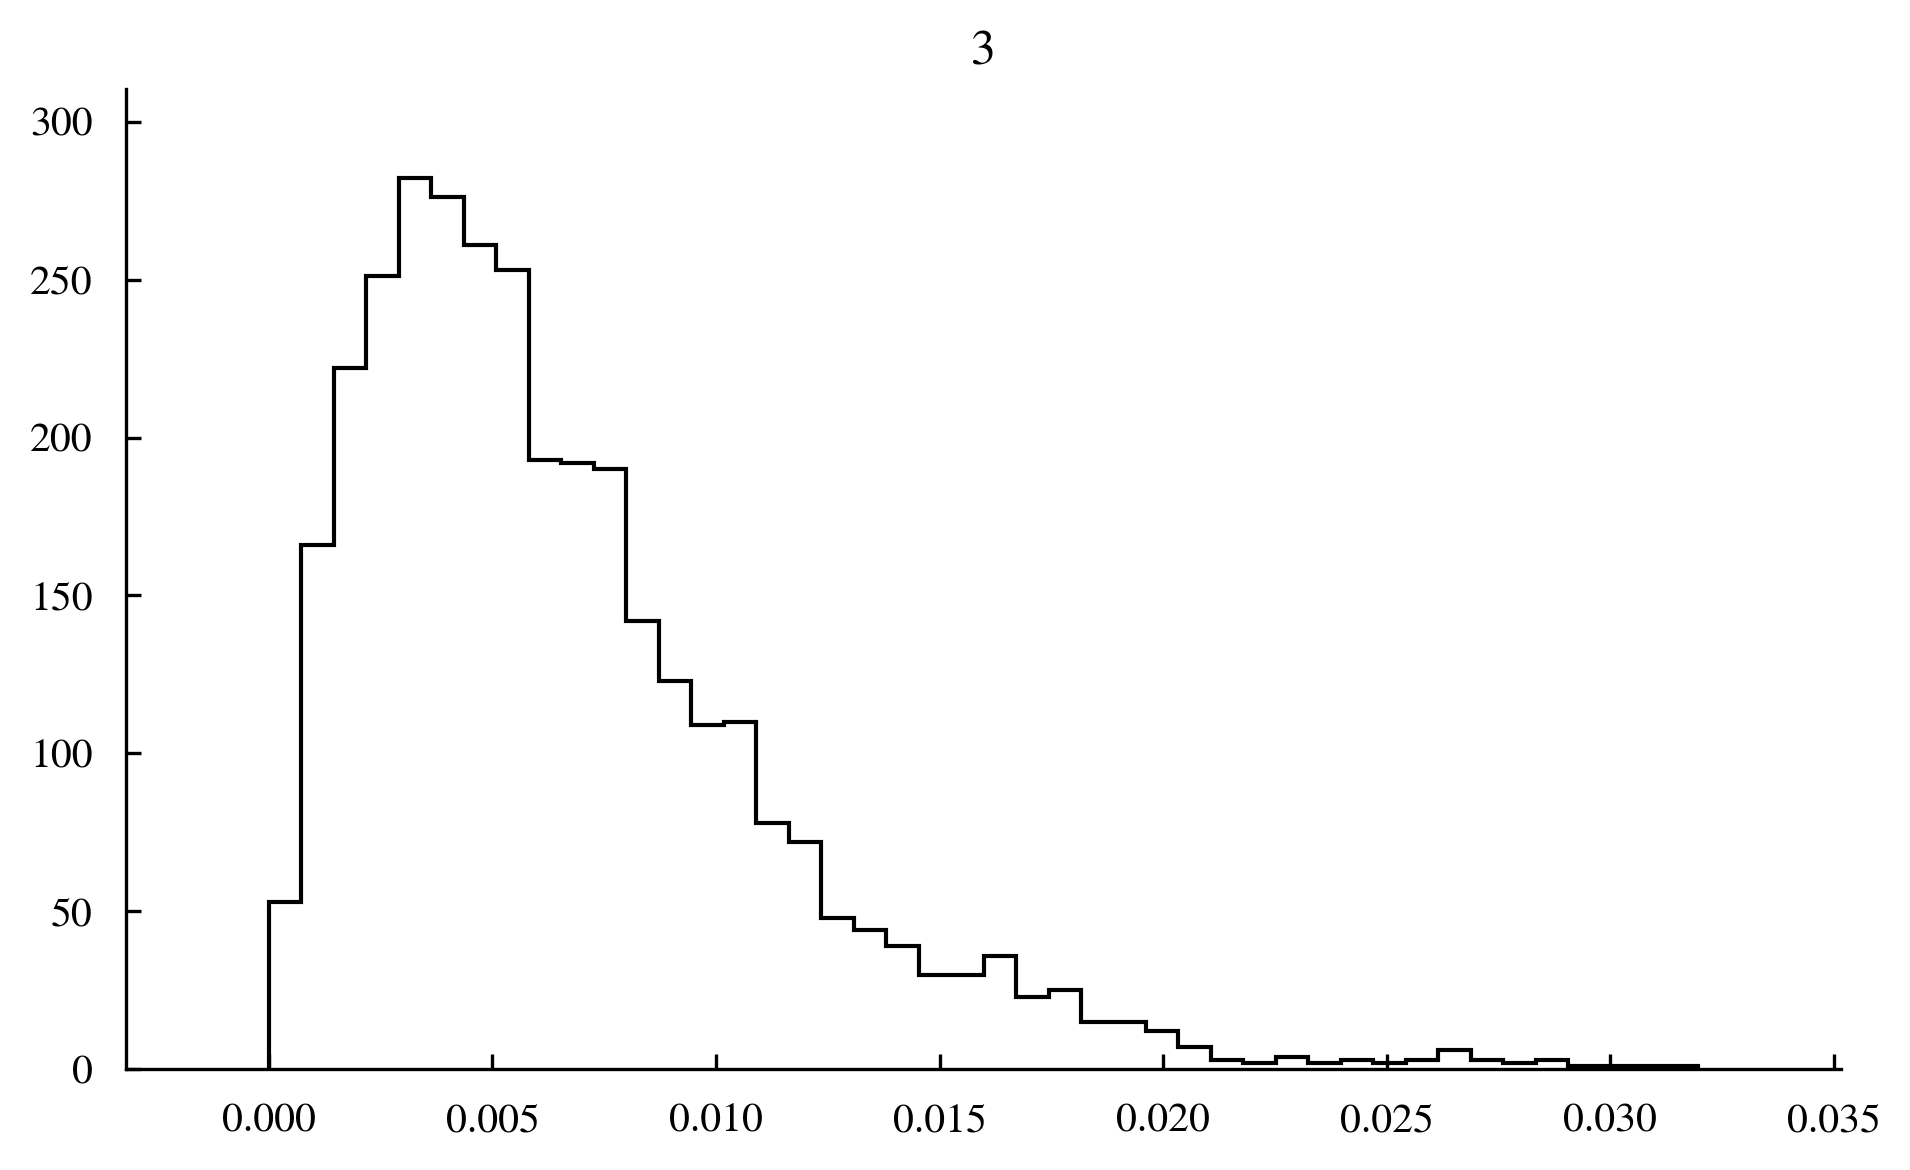

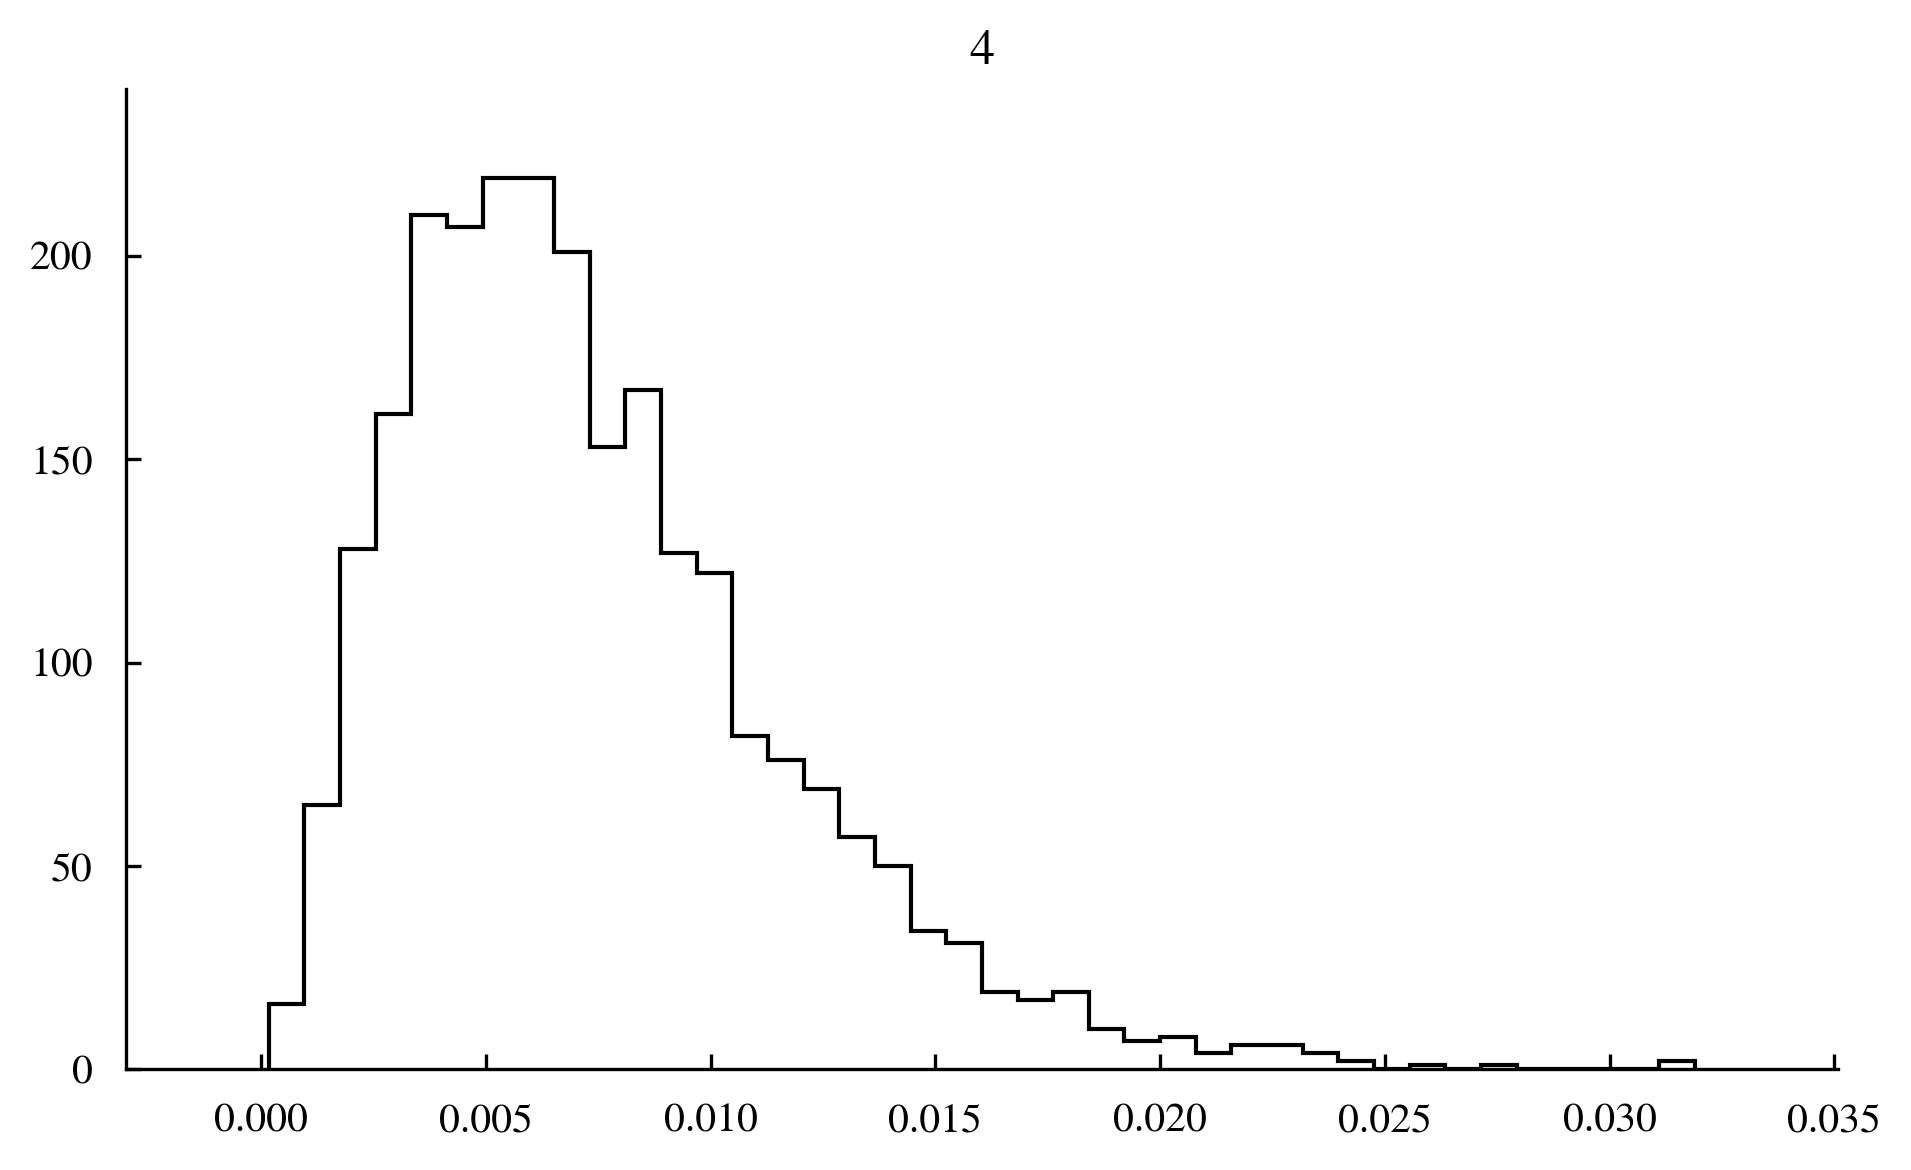

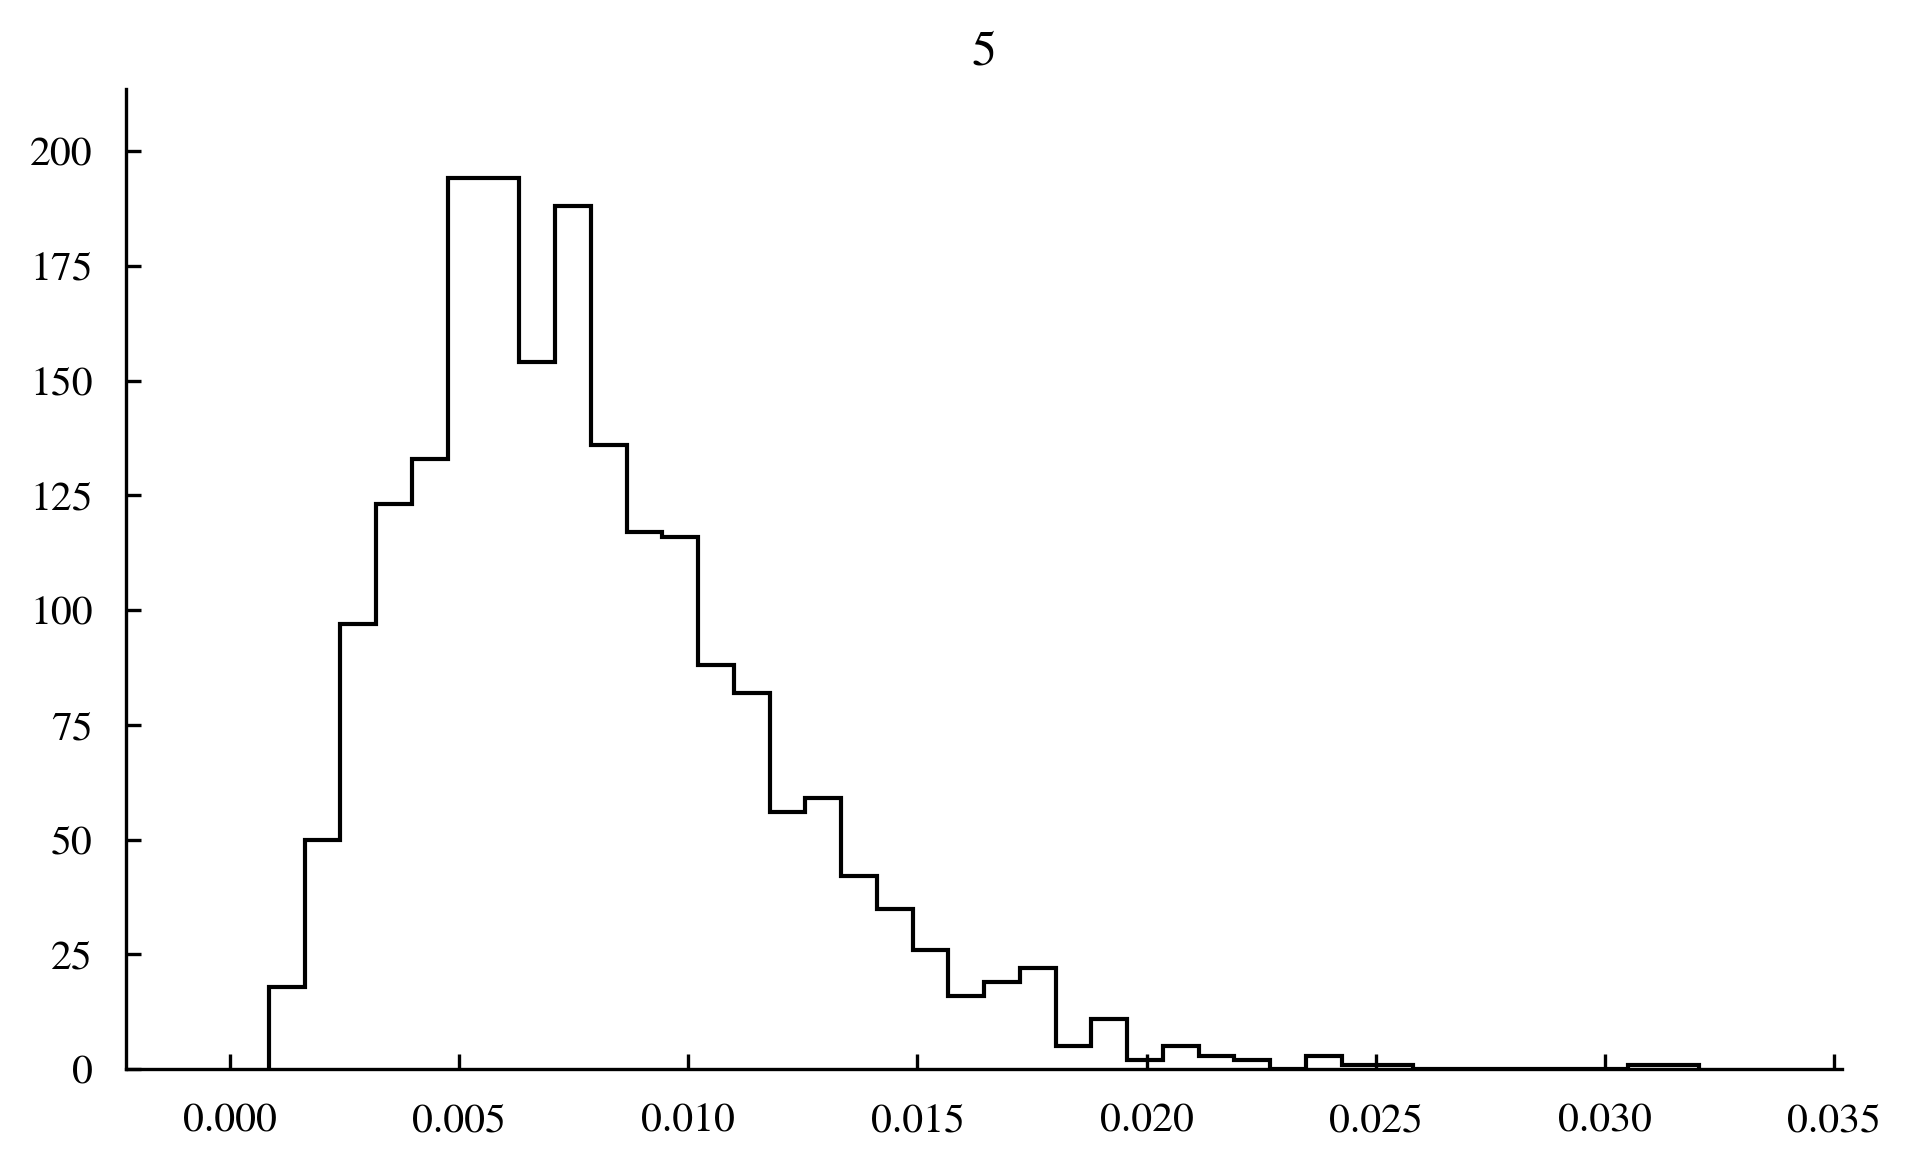

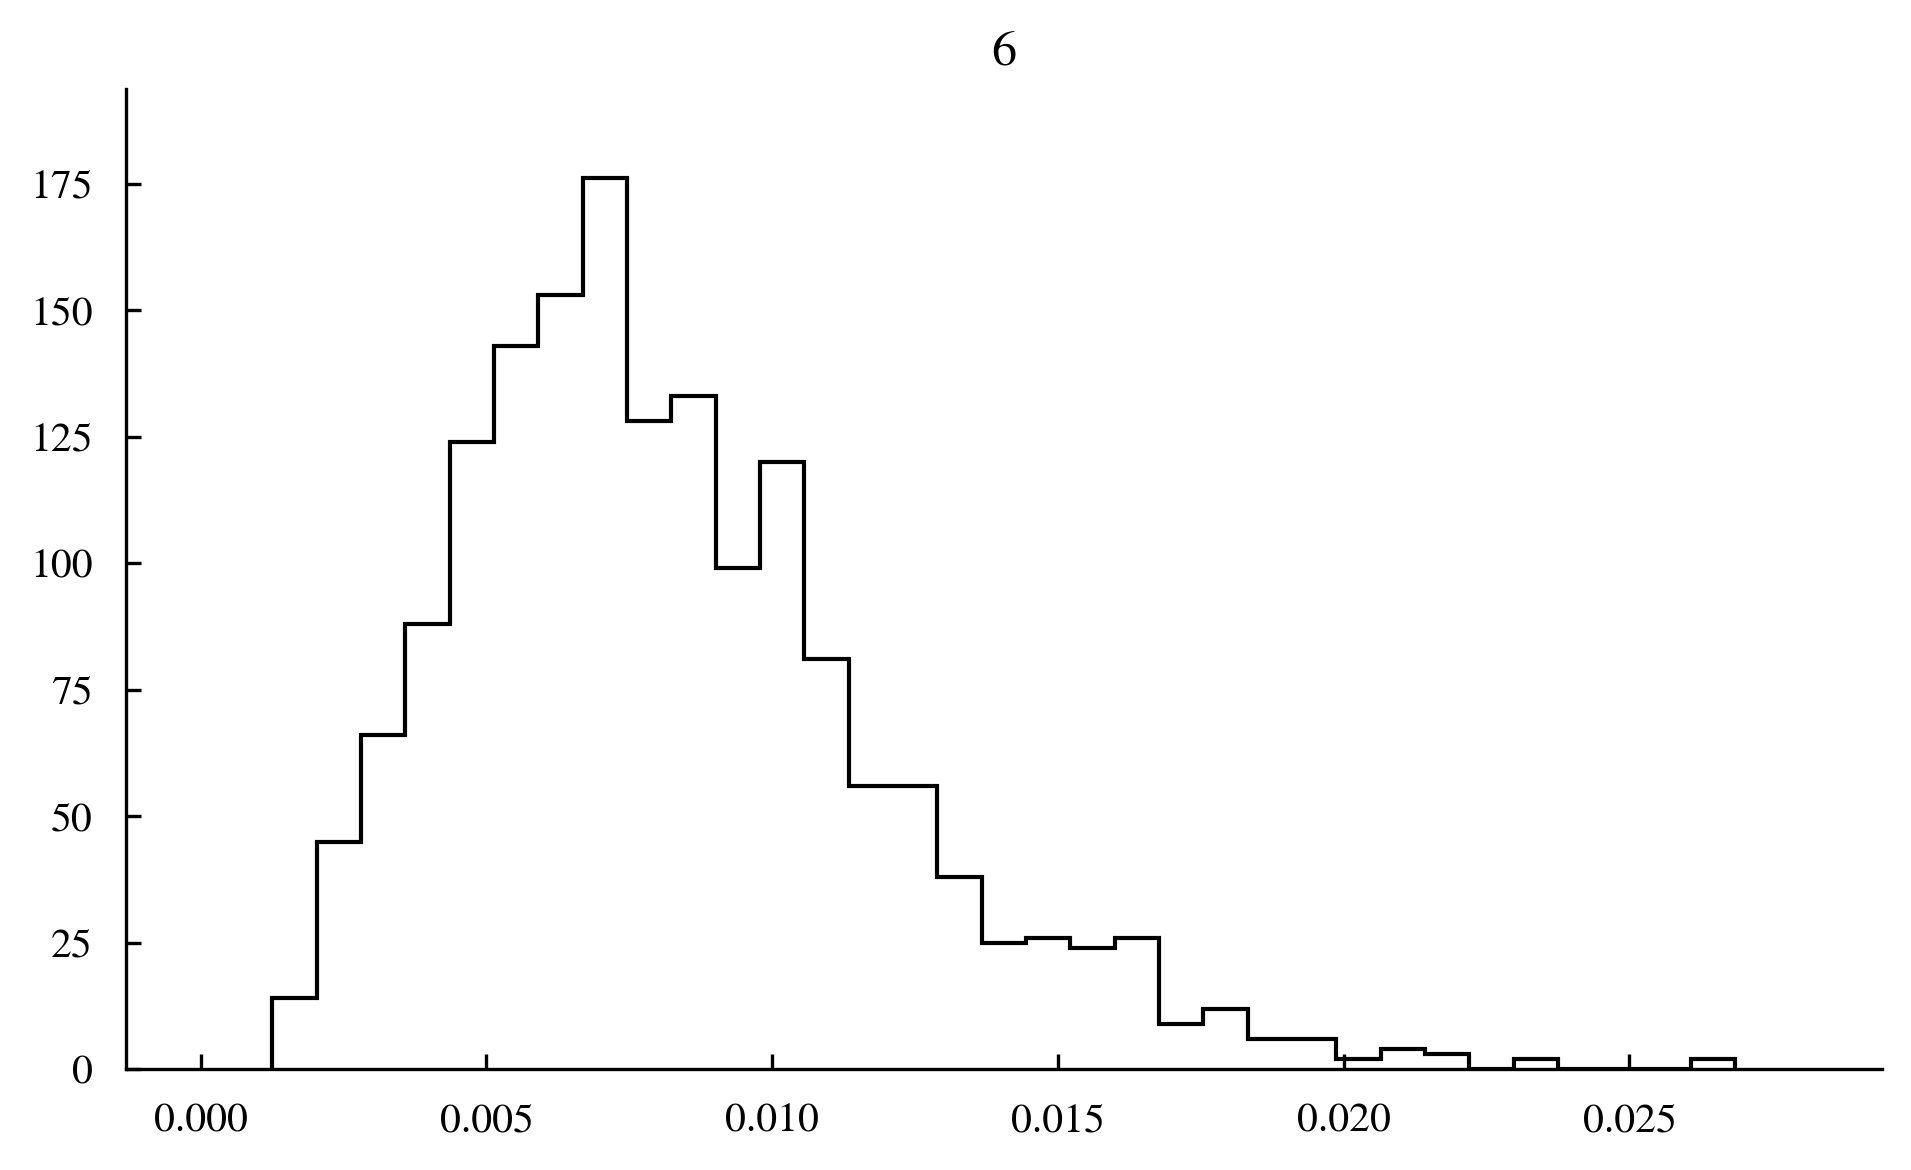

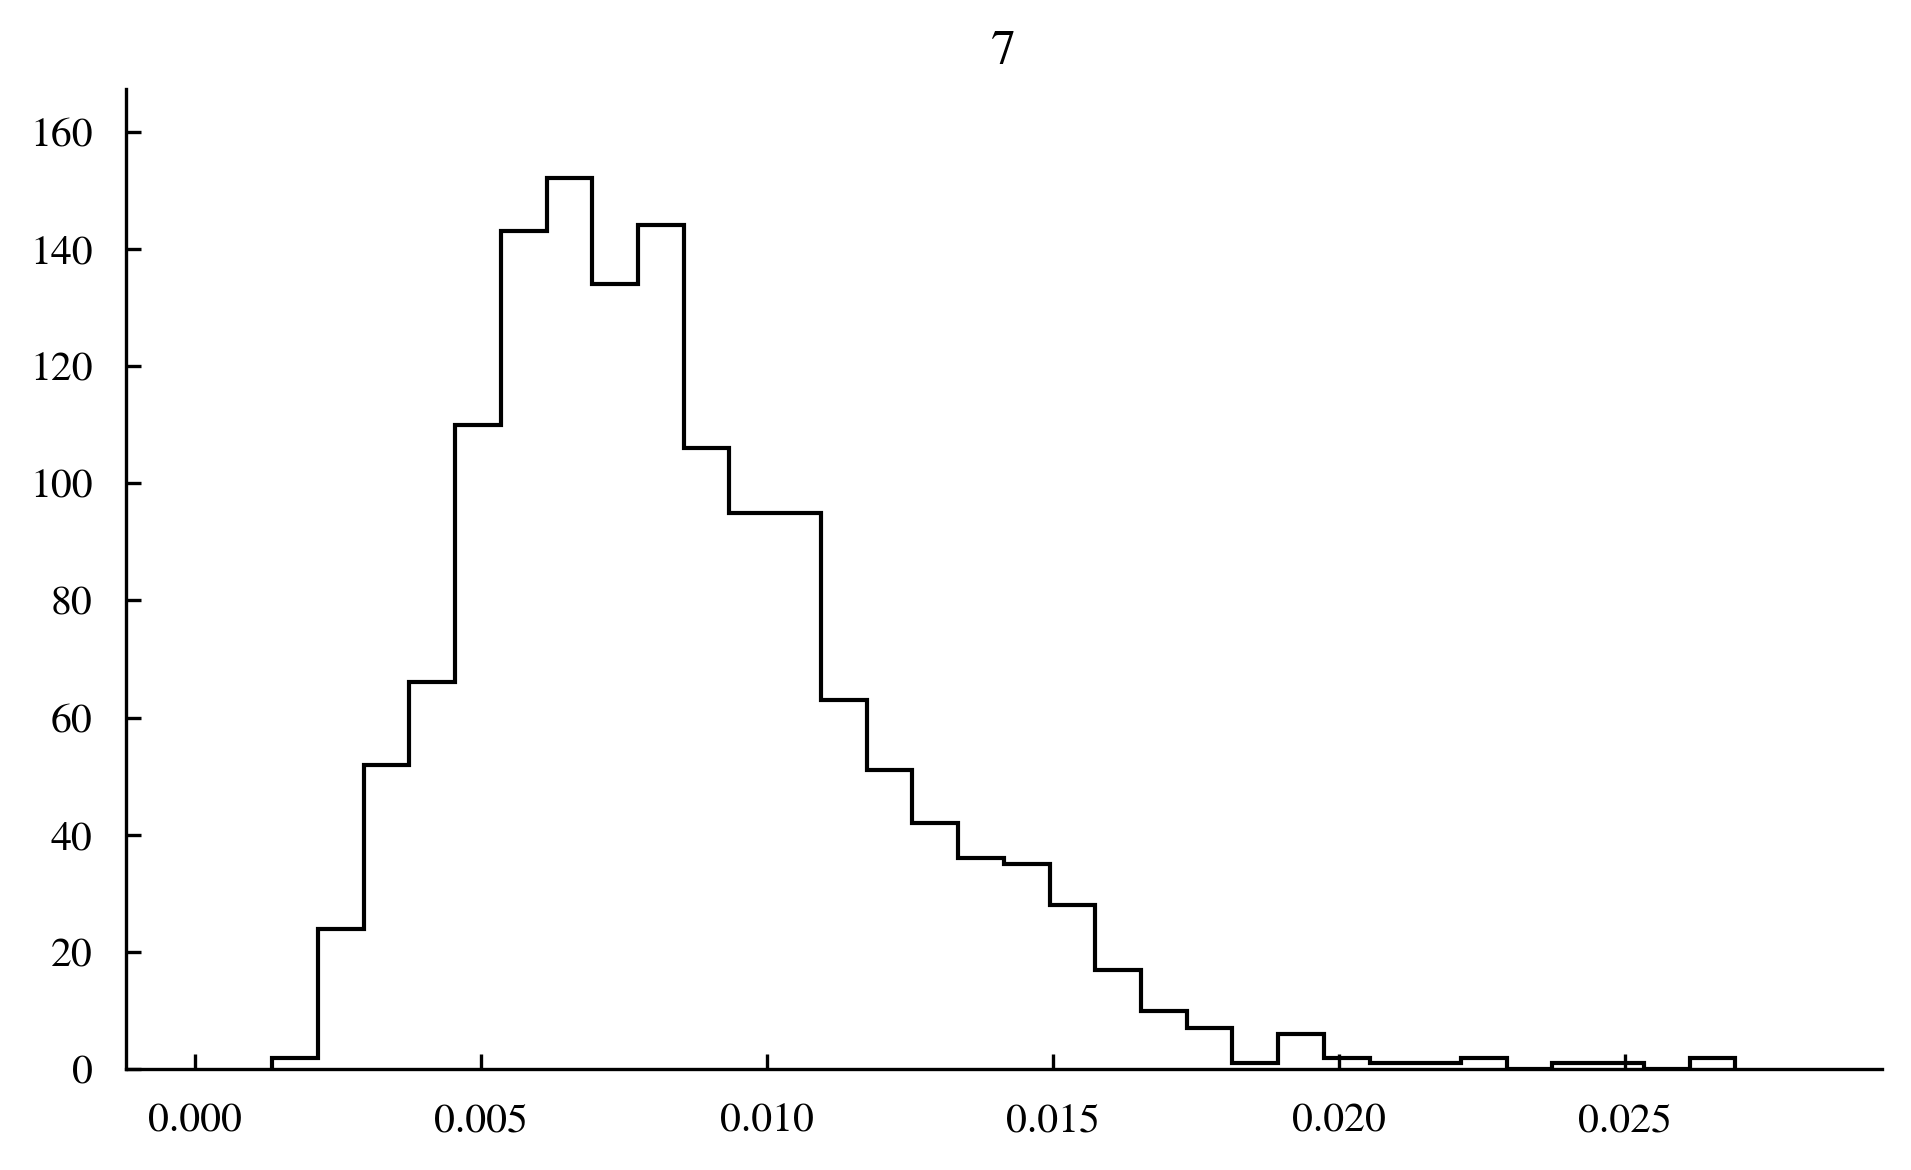

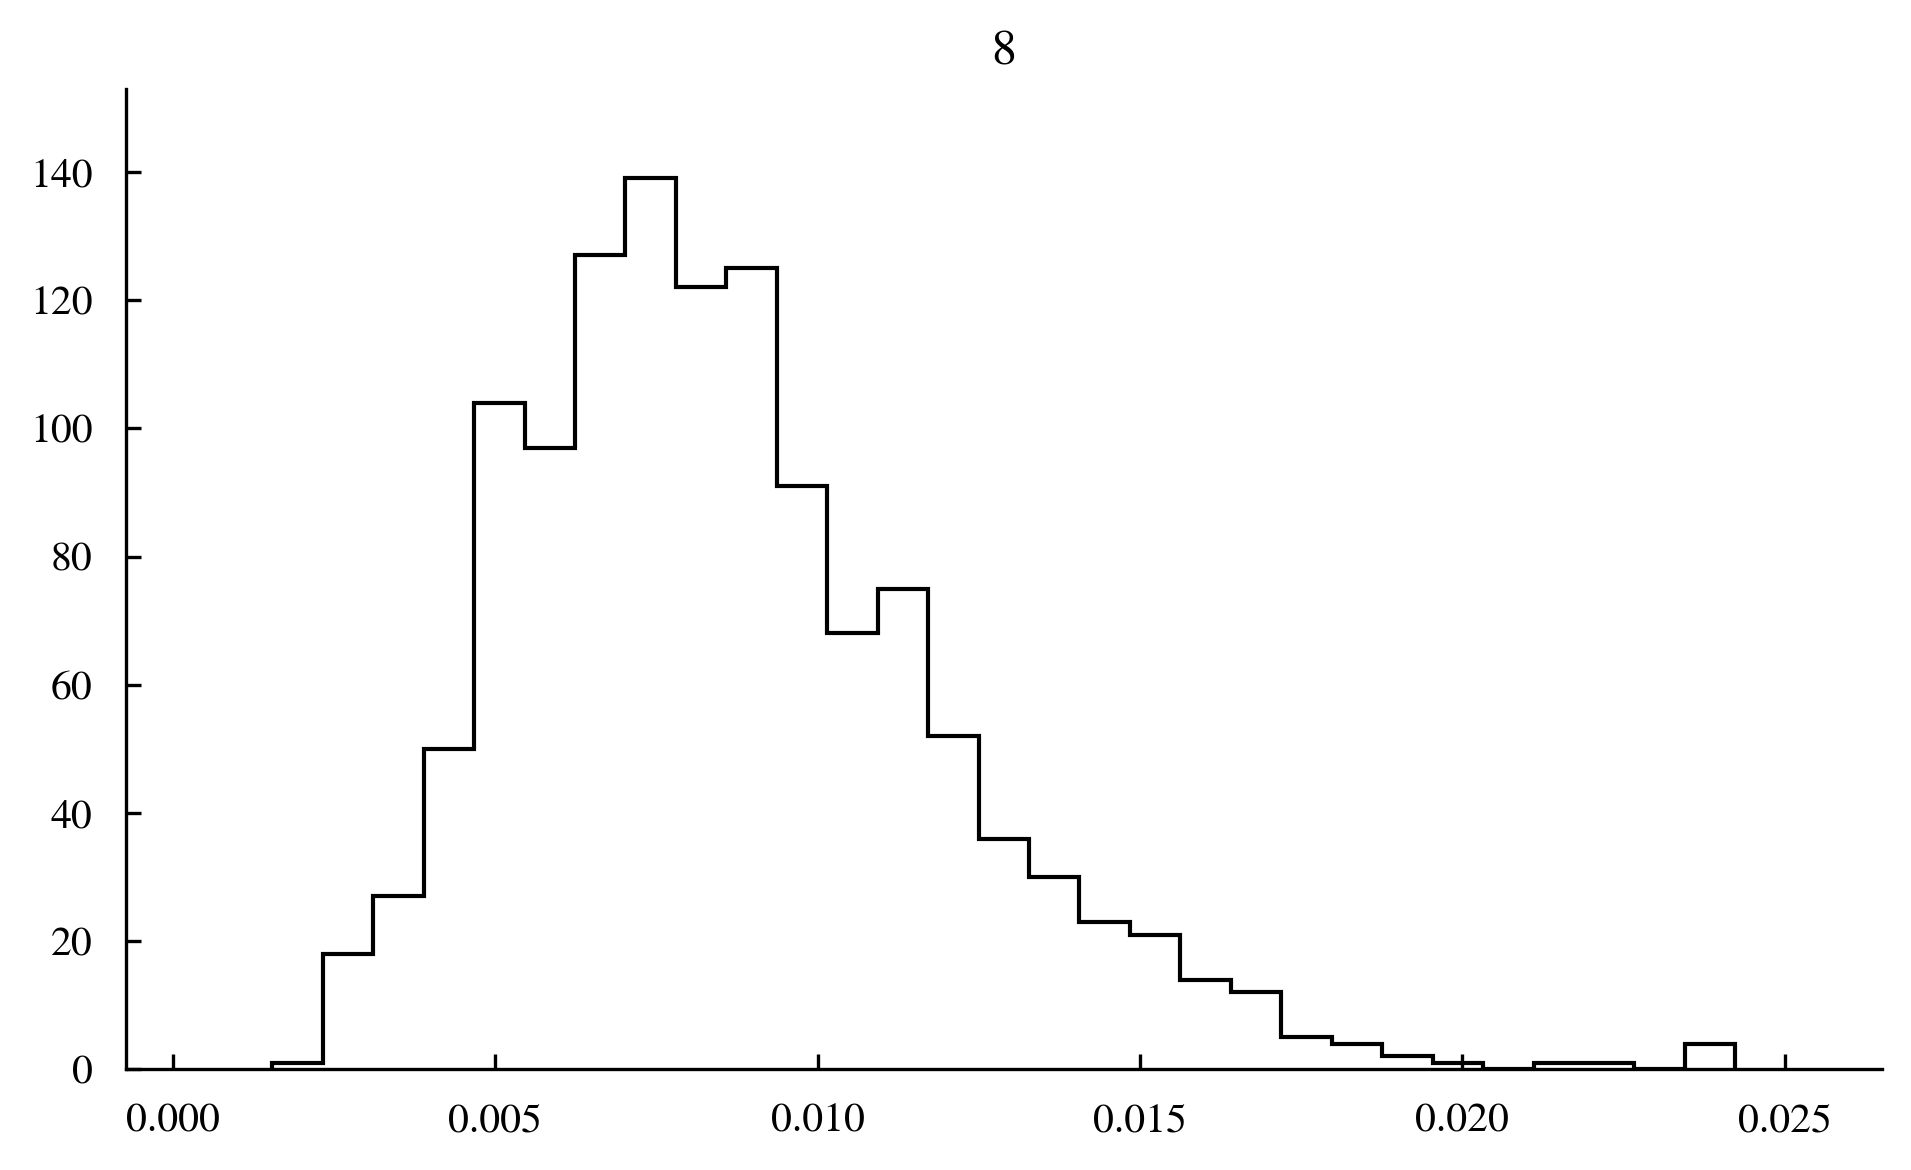

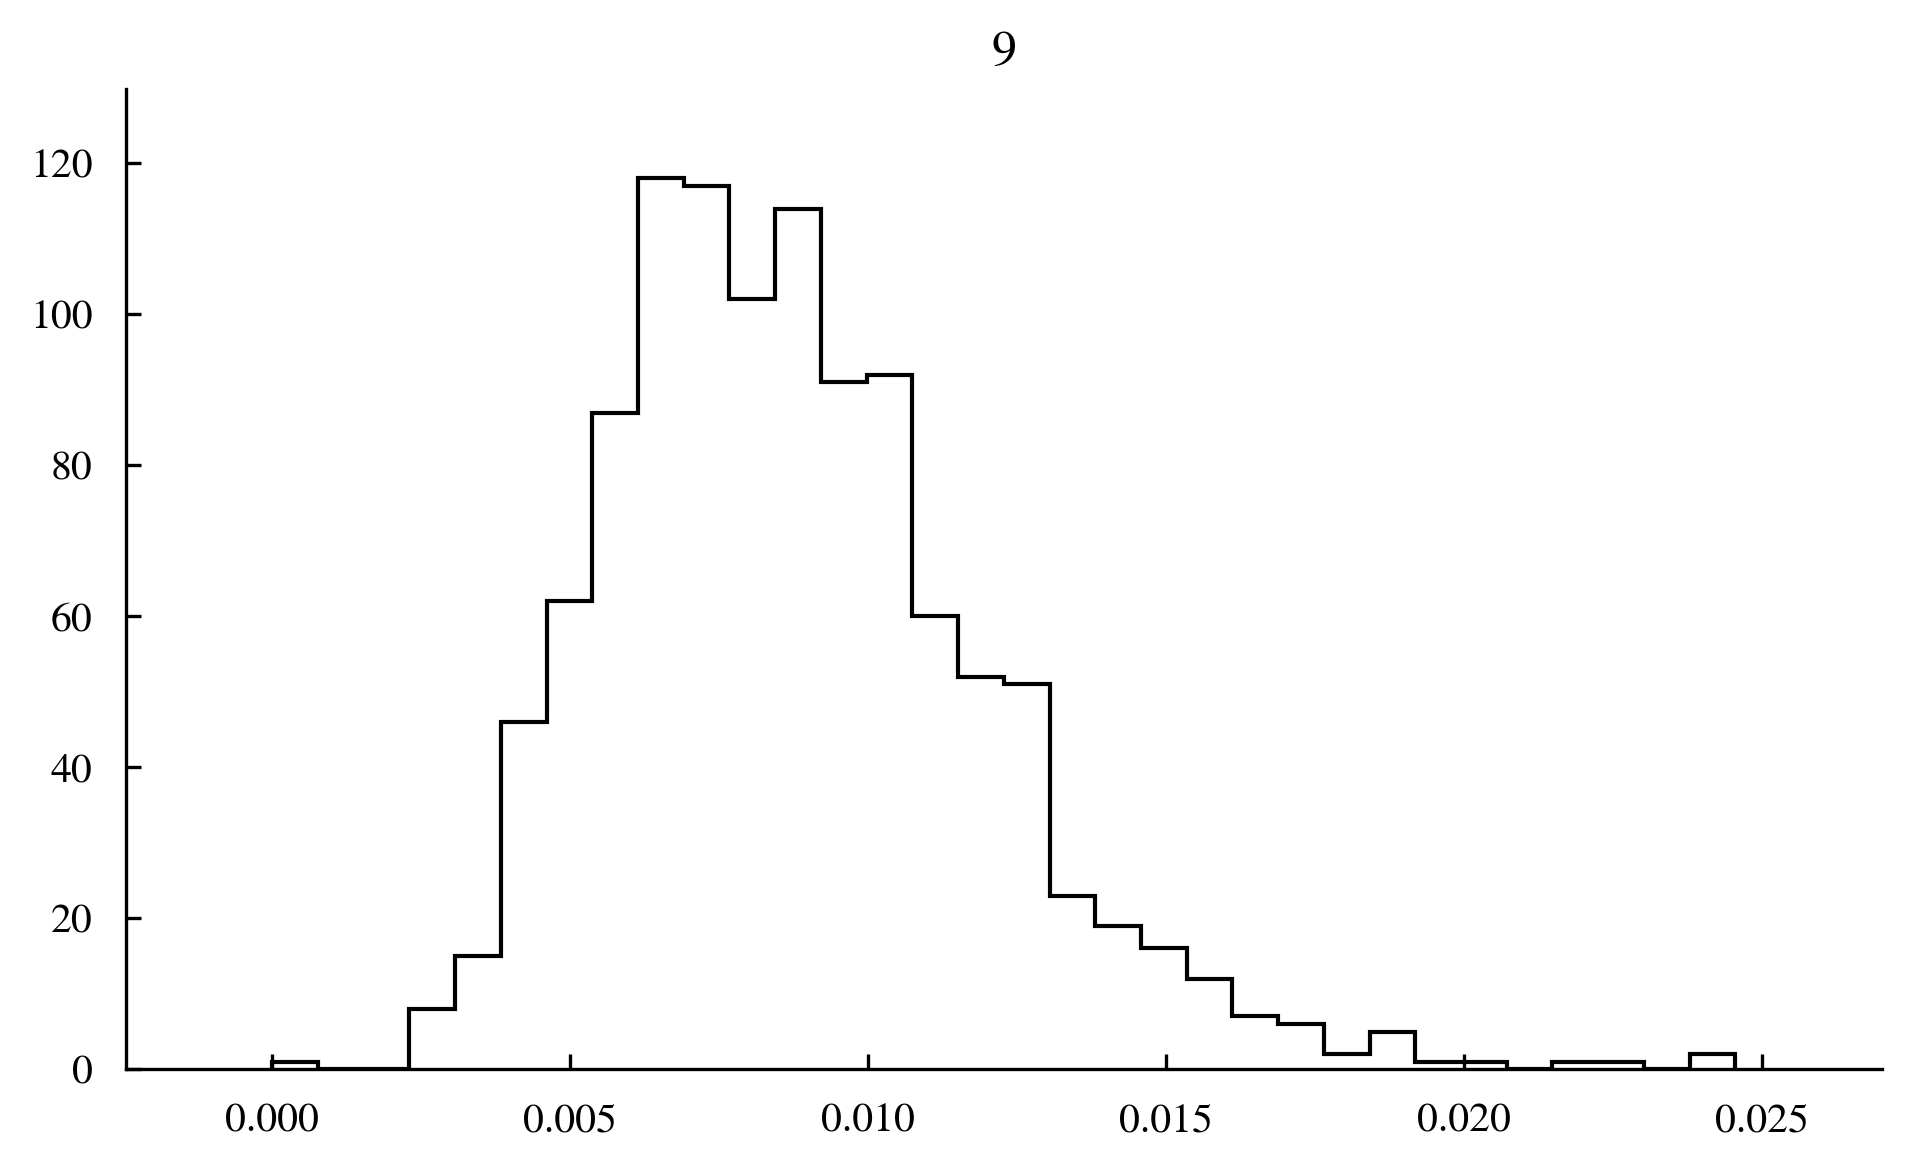

(array([929., 850., 809., 693., 641., 598., 527., 472., 451., 389., 340.,
        320., 297., 266., 226., 196., 191., 166., 144., 133., 152., 110.,
        121.,  89.,  93.,  70.,  85.,  64.,  53.,  46.,  56.,  39.,  35.,
         32.,  30.,  24.,  19.,  14.,  20.,  18.,  17.,  13.,  14.,  12.,
         12.,  12.,  16.,   7.,  13.,   8.,   8.,   4.,   7.,   7.,   5.,
          5.,   3.,   2.,   4.,   0.,   3.,   2.,   3.,   1.,   2.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   2.]),
 array([2.56868947e-06, 9.98301216e-04, 1.99403374e-03, 2.98976627e-03,
        3.98549880e-03, 4.98123132e-03, 5.97696385e-03, 6.97269638e-03,
        7.96842890e-03, 8.96416143e-03, 9.95989396e-03, 1.09556265e-02,
        1.19513590e-02, 1.29470915e-02, 1.39428241e-02, 1.49385566e-02,
        1.59342891e-02, 1.69300216e-02, 1.79257542e-02, 1.89214867e-02,
        1.99172192e-02, 2.09129517e-02, 2.1908

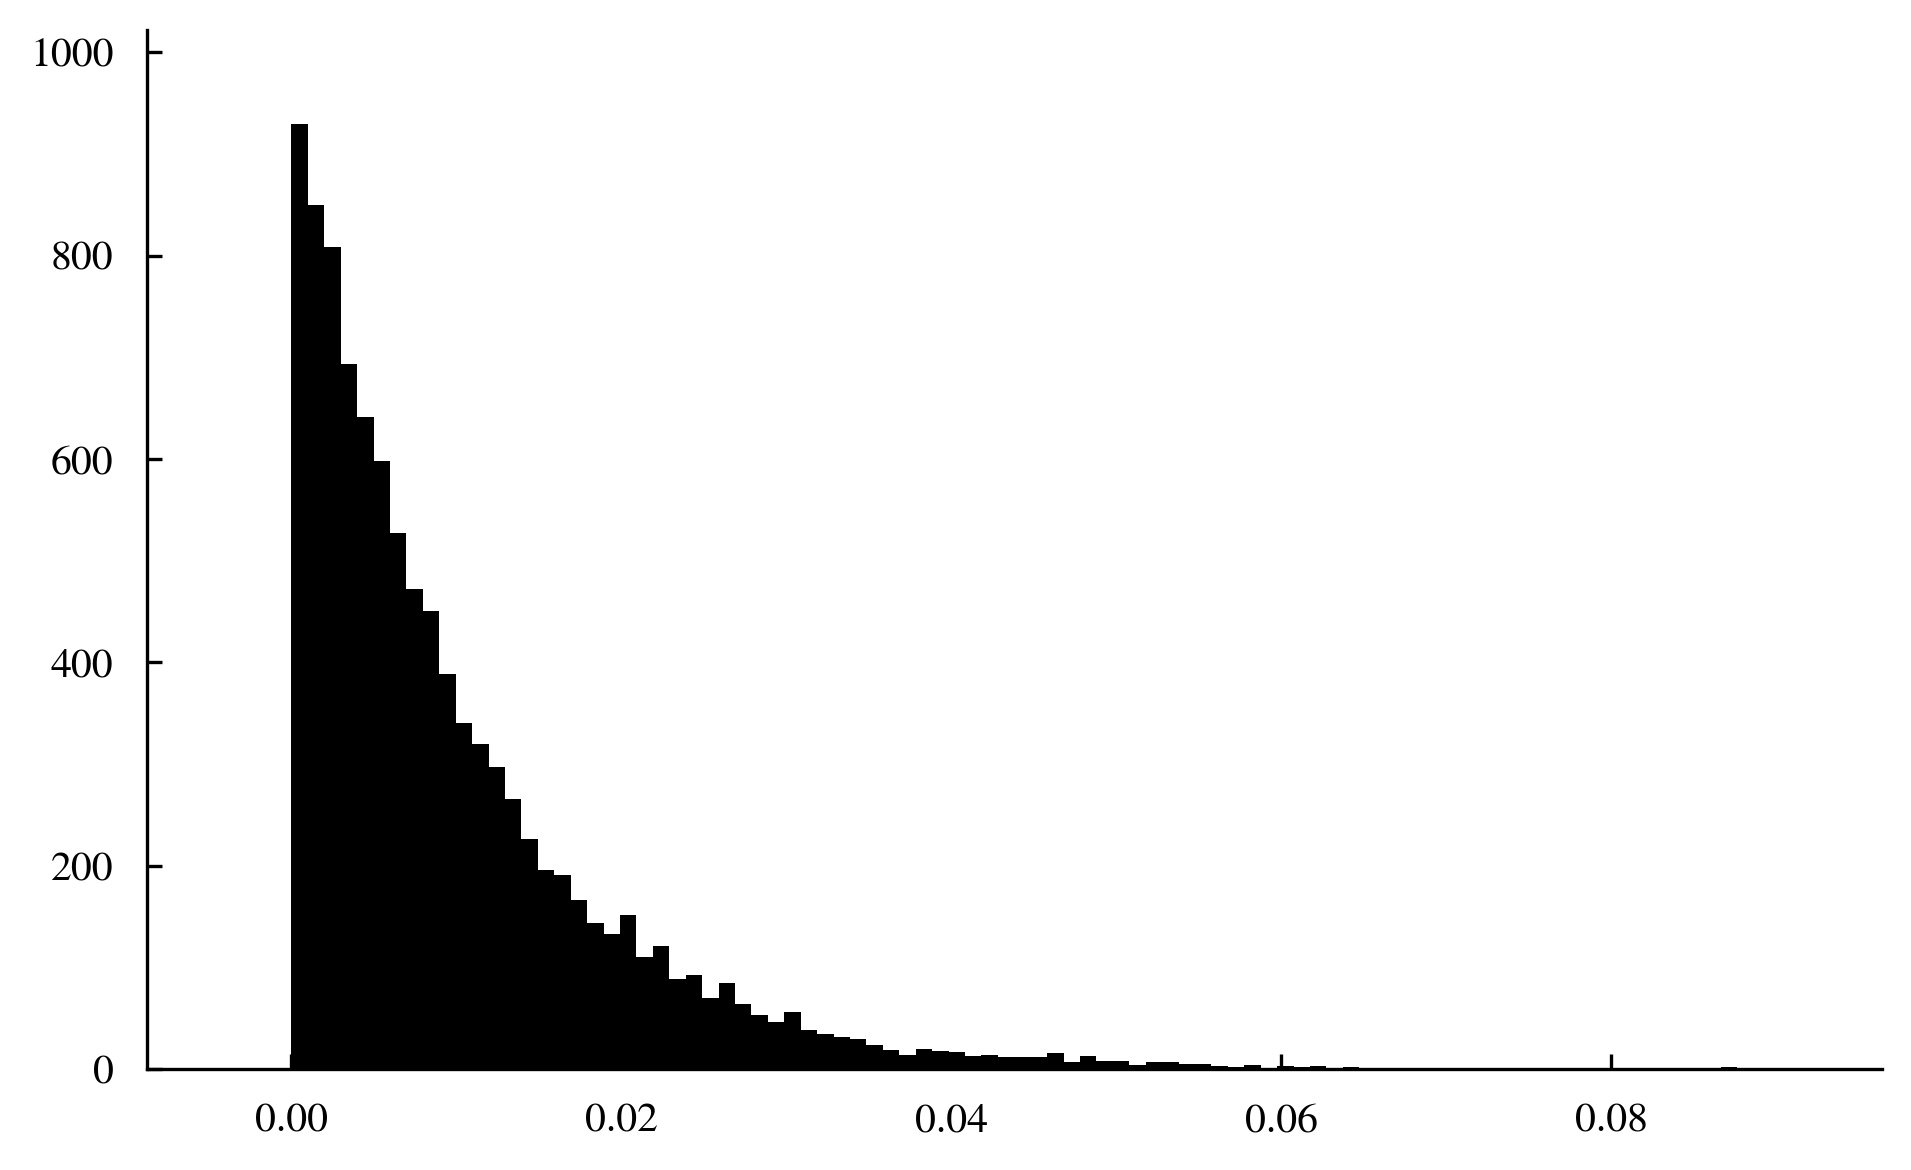

In [68]:
sim_sample = np.random.permutation(expon.rvs(0,.01,int(1e4)))

for mplet in range(3,10):
    fitted_args = list()
    for i in range(0,len(sim_sample),mplet):
        fitted_args.append(list(expon.fit(sim_sample[i:i+mplet])))
    fitted_args = np.array(fitted_args)
    plt.figure()
    plt.hist(fitted_args[:,1],histtype="step",bins="fd")
    plt.title(mplet)
    plt.show()
plt.figure()
plt.hist(sim_sample)
